In [17]:
import logging

# Configure logging to display debug messages
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage of logging
logging.debug("Debugging is enabled")

2024-10-29 10:25:11,899 - DEBUG - Debugging is enabled


In [18]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
from selenium_load import PageLoader

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "hackathon.slalom.com"
full_url = "https://hackathon.slalom.com/teams"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from html source
def get_hyperlinks(page_source):

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(page_source)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, page_source):
    clean_links = []
    for link in set(get_hyperlinks(page_source)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))


def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # Instantiate the PageLoader class
    driver_path = '/Users/michaelleonard/slalom/ask-about/Selenium.WebDriver.ChromeDriver.130.0.6723.6900/driver/mac64/chromedriver'
    page_loader = PageLoader(driver_path)

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Load the full text and source of the URL
        page_text, page_source = page_loader.get_text_and_source_from_page(url)

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:
            f.write(page_text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, page_source):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

2024-10-29 10:25:48,156 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Service class: /Users/michaelleonard/slalom/ask-about/Selenium.WebDriver.ChromeDriver.130.0.6723.6900/driver/mac64/chromedriver


2024-10-29 10:25:48,168 - DEBUG - Started executable: `/Users/michaelleonard/slalom/ask-about/Selenium.WebDriver.ChromeDriver.130.0.6723.6900/driver/mac64/chromedriver` in a child process with pid: 91179 using 0 to output -3
2024-10-29 10:25:48,261 - DEBUG - POST http://localhost:49215/session {'capabilities': {'firstMatch': [{}], 'alwaysMatch': {'browserName': 'chrome', 'pageLoadStrategy': <PageLoadStrategy.normal: 'normal'>, 'goog:chromeOptions': {'extensions': [], 'args': ['--headless']}}}}
2024-10-29 10:25:48,263 - DEBUG - Starting new HTTP connection (1): localhost:49215
2024-10-29 10:25:49,681 - DEBUG - http://localhost:49215 "POST /session HTTP/11" 200 0
2024-10-29 10:25:49,682 - DEBUG - Remote response: status=200 | data={"value":{"capabilities":{"acceptInsecureCerts":false,"browserName":"chrome","browserVersion":"130.0.6723.70","chrome":{"chromedriverVersion":"130.0.6723.69 (3ec172b971b9478c515a58f591112c5c23fa4965-refs/branch-heads/6723@{#1452})","userDataDir":"/var/folders/h

https://hackathon.slalom.com/teams


2024-10-29 10:25:53,778 - DEBUG - http://localhost:49215 "POST /session/ce3303ed3f568e36506e789e894b2f28/url HTTP/11" 200 0
2024-10-29 10:25:53,780 - DEBUG - Remote response: status=200 | data={"value":null} | headers=HTTPHeaderDict({'Content-Length': '14', 'Content-Type': 'application/json; charset=utf-8', 'cache-control': 'no-cache'})
2024-10-29 10:25:53,782 - DEBUG - Finished Request
2024-10-29 10:25:53,784 - DEBUG - POST http://localhost:49215/session/ce3303ed3f568e36506e789e894b2f28/element {'using': 'tag name', 'value': 'body'}
2024-10-29 10:25:53,803 - DEBUG - http://localhost:49215 "POST /session/ce3303ed3f568e36506e789e894b2f28/element HTTP/11" 200 0
2024-10-29 10:25:53,805 - DEBUG - Remote response: status=200 | data={"value":{"element-6066-11e4-a52e-4f735466cecf":"f.D714D1B1C926269E0383F9F983E7E8EE.d.17BB8A77830DCE716000B3939C9AABE2.e.13"}} | headers=HTTPHeaderDict({'Content-Length': '126', 'Content-Type': 'application/json; charset=utf-8', 'cache-control': 'no-cache'})
2024

https://hackathon.slalom.com/hackathons


MaxRetryError: HTTPConnectionPool(host='localhost', port=49215): Max retries exceeded with url: /session/ce3303ed3f568e36506e789e894b2f28/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x10b2c6cf0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [19]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [20]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,lalom.com teams,lalom.com teams. Slalom Build Hackathons Bro...


2024-10-29 11:53:19,222 - DEBUG - matplotlib data path: /Users/michaelleonard/slalom/ask-about/.venv/lib/python3.13/site-packages/matplotlib/mpl-data
2024-10-29 11:53:19,235 - DEBUG - CONFIGDIR=/Users/michaelleonard/.matplotlib
2024-10-29 11:53:19,261 - DEBUG - interactive is False
2024-10-29 11:53:19,262 - DEBUG - platform is darwin
2024-10-29 11:53:19,381 - DEBUG - CACHEDIR=/Users/michaelleonard/.matplotlib
2024-10-29 11:53:19,387 - DEBUG - Using fontManager instance from /Users/michaelleonard/.matplotlib/fontlist-v390.json
2024-10-29 11:53:20,578 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-29 11:53:20,582 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-29 11:53:20,595 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-10-29 11:53:20,597 - DEBUG - findfont: score(FontEntry(fname='/Users/michaelleonard/slalom/ask-about/.venv/lib/pyt

<Axes: >

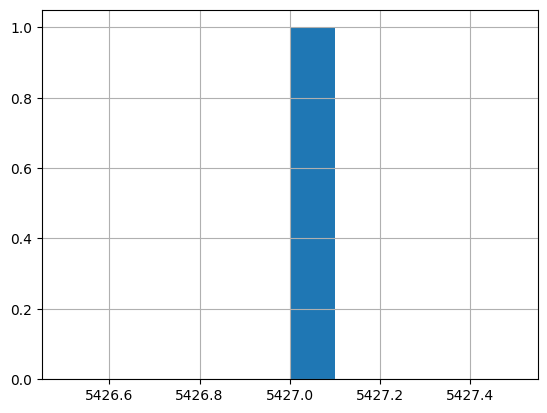

In [22]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [27]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

In [ ]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [ ]:
import openai

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

In [ ]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
answer_question(df, question="What day is it?", debug=False)

In [ ]:
answer_question(df, question="What is our newest embeddings model?")